In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.manual_seed(223)
np.random.seed(223)

## Tensors and relation to Numpy

pytorch中tensor和numpy几乎一模一样

但是numpy不会自动得到gradient，而torch的可以。两者也可以互相转换。

In [2]:
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(x_numpy, x_torch)

x_numpy, x_torch
[0.1 0.2 0.3] tensor([0.1000, 0.2000, 0.3000])


to and from numpy, pytorch

In [3]:
print(torch.from_numpy(x_numpy), x_torch.numpy())

tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64) [0.1 0.2 0.3]


we can do basic operations like + - * /

In [5]:
y_numpy = np.array([3,4,5])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(x_numpy + y_numpy, x_torch+y_torch)

x+y
[3.1 4.2 5.3] tensor([3.1000, 4.2000, 5.3000])


most functions in numpy also in pytorch

In [6]:
print("norm")
print(np.linalg.norm(x_numpy), torch.norm(x_torch))

norm
0.37416573867739417 tensor(0.3742)


To apply an operation along a dimension, we use the **dim** keyword argument instead of **axis**

In [7]:
print("mean along the 0th dimension")
x_numpy = np.array([[1,2],[3,4]])
x_torch = torch.tensor([[1,2],[3,4.]])
print(np.mean(x_numpy, axis=0), torch.mean(x_torch, dim=0))

mean along the 0th dimension
[2. 3.] tensor([2., 3.])


## Tensor.view

Tensor.view() function reshape tensors, similarity to numpy.**reshape()**

It can automatically calculate the correct dimension if a -1 is passed in. This is useful if we are working with batches but the batch size is unknown.

In [8]:
# "MNIST"
N, C, W, H = 10000, 2, 28, 28
X = torch.randn(N, C, W, H)

print(X.shape)
print(X.view(N, C, 28*28).shape)
print(X.view(-1, C, 28*28).shape) # automatically choose the 0the dimension

torch.Size([10000, 2, 28, 28])
torch.Size([10000, 2, 784])
torch.Size([10000, 2, 784])


## Broadcasting semantics

Two tensors are "broadcastable" if the following rules hold:

+ Each tensor has at least one dimension
+ When iterating over the dimension sizes, starting the tralling dimensions, the dimension sizes must either be equal, one of them is 1, one of them does not exit 

In [14]:
# pytorch operations support numpy broadcasting semantics
# 两个不相同的向量，想直接加起来
x = torch.empty(5, 1, 4, 1)
y = torch.empty(3, 1, 1)
print("x:",x, x.shape)
print("y:",y, y.shape)
print((x+y).size())

x: tensor([[[[0.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.]]]]) torch.Size([5, 1, 4, 1])
y: tensor([[[-4.6264e-11]],

        [[ 1.5449e-41]],

        [[-4.6264e-11]]]) torch.Size([3, 1, 1])
torch.Size([5, 3, 4, 1])


## computation graphs

pytorch tensor object implicitly creates a computation graph in the background.

A computation graph is a way of writing mathematical expression as a graph.

There is an algorithm to compute the gradients of all the variables of a computation graph in time on the same order it is to compute the function itself.

In [29]:
# set requires_grad=True to let Pytorch know to keep the graph
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
c = a+b
d = b+1
e = c*d
print('c',c)
print("d",d)
print('e',e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


## CUDA SEMANTICS

It is easy to copy tensor between cpu and gpu

In [30]:
cpu = torch.device("cpu")
gpu = torch.device("cuda")

x = torch.rand(10)
print(x)
x = x.to(gpu)
print(x)
x = x.to(cpu)
print(x)

tensor([0.7387, 0.7572, 0.8219, 0.2490, 0.9072, 0.1679, 0.6588, 0.4689, 0.6731,
        0.8119])


/home/zhouzy/softwares/Python-3.7.3/install/lib/python3.7/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU1 Quadro K600 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


tensor([0.7387, 0.7572, 0.8219, 0.2490, 0.9072, 0.1679, 0.6588, 0.4689, 0.6731,
        0.8119], device='cuda:0')
tensor([0.7387, 0.7572, 0.8219, 0.2490, 0.9072, 0.1679, 0.6588, 0.4689, 0.6731,
        0.8119])


## Auto grad

pytorch is an auto grad framework

Consider the function $f(x) = (x-2)^2$

Q: Compute $\frac{d}{dx} f(x)$ and then compute $f'(1)$.

**backward()** call on the leaf variable(y) in the computation, computes all the gradients of y at once

In [32]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('Pytorch back f\'(x):', x.grad)

Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
Pytorch back f'(x): tensor([-2.])


## Using the gradients

Now we have gradients, we can use our favorite optimization algorithm: gradient descent

Let $f$ be the same function we defined above

Q: Which x minimizes $f$ ?

In [34]:
x = torch.tensor([5.0], requires_grad=True)
step_size = 0.25

print('iter, \tx, \tf(x), \tf\'(x), \tf\'(x) pytorch')
for i in range(15):
    y = f(x)
    y.backward() #compute the gradient
    
    print('{}, \t{:.3f}, \t{:.3f}, \t{:.3f}, \t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    
    # .data返回的是一个tensor
    # 而.item()返回的是一个具体的数值
    x.data = x.data -step_size*x.grad # perform a GD update step
    
    # we need to zero the grad variable since the backward() call
    # accumulates the gradients in .grad instead of overwriting
    # The detach_() is for efficiency.
    # detach简单来说，就是截断反向传播的梯度流
    x.grad.detach_()
    x.grad.zero_()

iter, 	x, 	f(x), 	f'(x), 	f'(x) pytorch
0, 	5.000, 	9.000, 	6.000, 	6.000
1, 	3.500, 	2.250, 	3.000, 	3.000
2, 	2.750, 	0.562, 	1.500, 	1.500
3, 	2.375, 	0.141, 	0.750, 	0.750
4, 	2.188, 	0.035, 	0.375, 	0.375
5, 	2.094, 	0.009, 	0.188, 	0.188
6, 	2.047, 	0.002, 	0.094, 	0.094
7, 	2.023, 	0.001, 	0.047, 	0.047
8, 	2.012, 	0.000, 	0.023, 	0.023
9, 	2.006, 	0.000, 	0.012, 	0.012
10, 	2.003, 	0.000, 	0.006, 	0.006
11, 	2.001, 	0.000, 	0.003, 	0.003
12, 	2.001, 	0.000, 	0.001, 	0.001
13, 	2.000, 	0.000, 	0.001, 	0.001
14, 	2.000, 	0.000, 	0.000, 	0.000


## Linear Regression
Lets minimize a loss function on some made-up data

We will implement Gradient Descent to solve linear regression

In [43]:
# make a simple linear dataset with some noise

d = 2
n = 50
X = torch.randn(n, d)
true_w = torch.tensor([[-1.0], [2.0]])

#在python 3.5以后，@是一个操作符，表示矩阵-向量乘法
#A@x 就是矩阵-向量乘法A*x: np.dot(A, x)
y = X@true_w + torch.randn(n, 1)*0.1

print(X.shape, y.shape, true_w.shape)

torch.Size([50, 2]) torch.Size([50, 1]) torch.Size([2, 1])


In [37]:
# define a linear model with no bias
def model(X, w):
    return X @ w

# the residual sum of squares loss function
def rss(y, y_hat):
    return torch.norm(y-y_hat)**2/n

# analytical expression for the gradient
def grad_rss(X, y, w):
    return -2*X.t()@(y - X@w)/n

w = torch.tensor([[1.], [0]], requires_grad=True)
y_hat = model(X, w)

loss = rss(y, y_hat)
loss.backward()

print('Analytical gradient:', grad_rss(X, y, w).detach().view(2).numpy())
print('Pytorch gradient:', w.grad.view(2).numpy())

Analytical gradient: [ 2.2574904 -3.780513 ]
Pytorch gradient: [ 2.2574897 -3.7805133]


### using GD with automatically computes derivatives

In [44]:
step_size = 0.1

print('iter, \tloss, \tw')
for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    
    loss.backward() # compute the gradient of the loss
    
    w.data = w.data - step_size * w.grad # do a gradient descent step
    
    print('{}, \t{:.2f}, \t{}'.format(i, loss.item(), w.view(2).detach().numpy()))
    
    # we need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    w.grad.detach() #for efficiency, 这一句也可以去掉
    w.grad.zero_()

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', w.view(2).detach().numpy())

iter, 	loss, 	w
0, 	0.01, 	[-1.0010303  2.0016782]
1, 	0.01, 	[-1.0010928  1.9975625]
2, 	0.01, 	[-1.0012329  1.9943274]
3, 	0.01, 	[-1.0014182  1.9917825]
4, 	0.01, 	[-1.0016263  1.989779 ]
5, 	0.01, 	[-1.0018413  1.9882004]
6, 	0.01, 	[-1.0020531  1.9869554]
7, 	0.01, 	[-1.0022551  1.9859726]
8, 	0.01, 	[-1.0024433  1.9851962]
9, 	0.01, 	[-1.0026157  1.9845821]
10, 	0.01, 	[-1.0027715  1.9840958]
11, 	0.01, 	[-1.0029109  1.9837104]
12, 	0.01, 	[-1.0030344  1.9834046]
13, 	0.01, 	[-1.0031432  1.9831617]
14, 	0.01, 	[-1.0032384  1.9829684]
15, 	0.01, 	[-1.0033213  1.9828147]
16, 	0.01, 	[-1.0033932  1.982692 ]
17, 	0.01, 	[-1.0034553  1.9825941]
18, 	0.01, 	[-1.0035088  1.9825158]
19, 	0.01, 	[-1.0035547  1.9824532]

true w		 [-1.  2.]
estimated w	 [-1.0035547  1.9824532]


## torch.nn.Module

Module is PyTorch's way of performing operations in tensors. 

Modules are implemented as subclasses of the torch.nn.Module class. All modules are callable and can be compossed together to create complex functions.

torch.nn [docs](https://pytorch.org/docs/stable/nn.html)

Note: most of the functionality implemented for modules can be accessed in a functional form via torch.nn.functional. But these require you to create and manage the weight tensors yourself.

torch.nn.functional [docs](https://pytorch.org/docs/stable/nn.html#torch-nn-functional)

### Linear Module

It takes the input and output dimensions as parameters, and creates the weights in the object.

Unlike we initialized our $w$ manually, the Linear module **automatically** initializes the weights **randomly**. 

For minimizing non convex loss function(e.g. neural networks), initialization is important and can affect results. If training is not working as expected, **try to manually initializing the weights** different from the default. Pytorch implements some common initializations in torch.nn.init.

torch.nn.init [docs](https://pytorch.org/docs/stable/nn.html#torch-nn-init)

In [45]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1., 2, 3], [4, 5, 6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)

print('w:', linear_module.weight, ', b:', linear_module.bias)

w: Parameter containing:
tensor([[-0.3970,  0.1492, -0.4727],
        [ 0.3516,  0.1003, -0.1688],
        [ 0.3627,  0.2657, -0.0562],
        [ 0.5693, -0.0235,  0.4763]], requires_grad=True) , b: Parameter containing:
tensor([ 0.0619, -0.5457,  0.0056, -0.1865], requires_grad=True)


### Activation functions

Pytorch implements a number of activation functions including ReLU, Tanh, Sigmoid.

Since they are modules, they need to be instantiated.

In [46]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print("example tensor:",example_tensor)
print("activated:", activated)

example tensor: tensor([-1.,  1.,  0.])
activated: tensor([0., 1., 0.])


### Sequential

torch.nn.Sequential provides a good interface for composing simple modules.

In [48]:
d_in = 3
d_hidden = 4
d_out = 1
model = torch.nn.Sequential(
                nn.Linear(d_in, d_hidden),
                nn.Tanh(),
                nn.Linear(d_hidden, d_out),
                nn.Sigmoid()
        )
example_tensor = torch.tensor([[1., 2, 3], [4, 5, 6]])
transformed = model(example_tensor)
print("transformed:", transformed)

transformed: tensor([[0.4031],
        [0.5383]], grad_fn=<SigmoidBackward>)


**Note:** We can access all the parameters(of any nn.Module) with the $parameters()$ method

In [49]:
params = model.parameters()

for param in params:
    print(param)

Parameter containing:
tensor([[ 0.4671,  0.2967, -0.2291],
        [ 0.0093,  0.5333,  0.5189],
        [-0.2274,  0.2020,  0.4496],
        [-0.1831, -0.1396, -0.5206]], requires_grad=True)
Parameter containing:
tensor([-0.4898, -0.0881, -0.5568,  0.0661], requires_grad=True)
Parameter containing:
tensor([[ 0.4991, -0.4699,  0.1489, -0.2345]], requires_grad=True)
Parameter containing:
tensor([-0.2072], requires_grad=True)


### Loss functions

PyTorch implements many common loss functions including $MSE Loss$ and $CrossEntropy Loss$

In [51]:
mse_loss_fn = nn.MSELoss()

input = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(input, target)
print(loss)

tensor(0.6667)


### torch.optim

Pytorch implements a number of gradient-based optimization methods in $torch.optim$, including Gradient Descent. It takes in the model parameters and a learning rate at minimum.

Optimizers do not compute the gradient for you. you must call **backward()** yourself. You also must call the **optim.zero_grad()** function **before calling backward()** since by default PyTorch does and inplace add the .grad member variable rather than overwriting it.

zero_grad() does both the detach() and zero_() calls on tensor's grad variables.

torch.optim [docs](https://pytorch.org/docs/stable/optim.html)

In [53]:
# create a simple model
model = nn.Linear(1, 1)

# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad()
loss.backward()
optim.step()

print("model params after:", model.weight)

model params before: Parameter containing:
tensor([[0.6078]], requires_grad=True)
model params after: Parameter containing:
tensor([[0.6347]], requires_grad=True)


### Linear regression example

#### Using GD with automatically computed derivatives and PyTorch's Modules

Solve linear regression in a Pytorch way

In [54]:
step_size = 0.1

linear_module = nn.Linear(d, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter, \tloss, \tw')

for i in range(20):
    y_hat = linear_module(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter, 	loss, 	w
0,	6.94,	[0.23284763 0.45748812]
1,	4.23,	[-0.01339279  0.8107575 ]
2,	2.58,	[-0.20953633  1.0830404 ]
3,	1.57,	[-0.3659706  1.2927663]
4,	0.96,	[-0.4908944  1.4541929]
5,	0.59,	[-0.5907848  1.5783463]
6,	0.37,	[-0.6707639  1.6737511]
7,	0.23,	[-0.7348866  1.7469952]
8,	0.15,	[-0.78636616  1.8031676 ]
9,	0.09,	[-0.82775193  1.846198  ]
10,	0.06,	[-0.8610687  1.8791192]
11,	0.04,	[-0.88792664  1.9042706 ]
12,	0.03,	[-0.9096076  1.923456 ]
13,	0.02,	[-0.9271335  1.9380647]
14,	0.02,	[-0.94131994  1.9491668 ]
15,	0.01,	[-0.95281875  1.9575853 ]
16,	0.01,	[-0.9621516  1.963953 ]
17,	0.01,	[-0.9697364  1.968756 ]
18,	0.01,	[-0.9759086  1.9723668]
19,	0.01,	[-0.9809376  1.9750714]

true w		 [-1.  2.]
estimated w	 [-0.9809376  1.9750714]


#### Linear regression with SGD

previous examples, we computed the average gradient over the entire dataset(Gradient Descent). We can implement Stochastic Gradient Descent with a simple modification.

In [55]:
step_size = 0.1

linear_module = nn.Linear(d, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter, \tloss, \tw')

for i in range(200):
    rand_idx = np.random.choice(n) # take a random point from the dataset
    x = X[rand_idx]
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y[rand_idx]) # only compute the loss on the single point
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 20 == 0:
        print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter, 	loss, 	w
0,	4.51,	[-0.53437257  0.02807745]
20,	0.13,	[-0.8789126  2.0364408]
40,	0.01,	[-1.0130086  1.9781419]
60,	0.00,	[-1.0464606  1.9671909]
80,	0.02,	[-1.0403302  1.9768254]
100,	0.00,	[-1.0423443  1.9765073]
120,	0.01,	[-1.0502714  1.9967372]
140,	0.00,	[-1.0339669  1.9758096]
160,	0.01,	[-0.9581799  2.0230825]
180,	0.01,	[-1.0368613  1.953854 ]

true w		 [-1.  2.]
estimated w	 [-0.9779671  1.9938502]


## Neural Network Basics in PyTorch

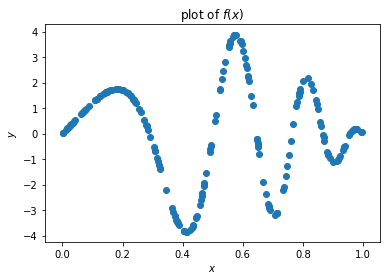

In [58]:
%matplotlib inline

d = 1 
n = 200
X = torch.rand(n, d)
y = 4*torch.sin(np.pi * X) * torch.cos( 6 * np.pi * X**2)

plt.scatter(X.numpy(), y.numpy())
plt.title('plot of $f(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

Here we define a simple two hidden layer neural network with Tanh activations. 

There are a few hyper parameter to play with to get a feel of how they change the results.

In [59]:
step_size = 0.1
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 64
d_out = 1

neural_network = nn.Sequential(
                    nn.Linear(d, n_hidden_1),
                    nn.Tanh(),
                    nn.Linear(n_hidden_1, n_hidden_2),
                    nn.Tanh(),
                    nn.Linear(n_hidden_2, d_out)
                    )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{}, \t{:.2f}'.format(i, loss.item()))

iter,	loss
0, 	4.12
600, 	3.46
1200, 	1.46
1800, 	0.67
2400, 	0.49
3000, 	0.18
3600, 	0.13
4200, 	0.23
4800, 	0.10
5400, 	0.03


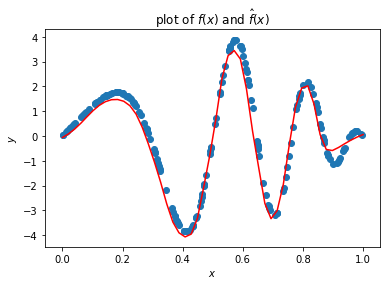

In [60]:
X_grid = torch.from_numpy(np.linspace(0, 1, 50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')

plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## Things helpful for homework

### Brief Sidenote: Momentum

There are other optimization algorithms besides SGD. One is a modification of SGD called momemtum. [ref](https://distill.pub/2017/momentum/)

We change the step size and add the momentum keyword argument to the optimizer. Notice it reduces the training loss in fewer iterations.

In [67]:
step_size = 0.05
momentum = 0.9
n_epochs = 1500
n_hidden_1 = 64
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                    nn.Linear(d, n_hidden_1),
                    nn.Tanh(),
                    nn.Linear(n_hidden_1, n_hidden_2),
                    nn.Tanh(),
                    nn.Linear(n_hidden_2, d_out)
                    )
loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size, momentum = momentum)

print('iter, \tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))

iter, 	loss
0,	4.21
150,	1.13
300,	0.25
450,	0.06
600,	0.07
750,	0.02
900,	0.00
1050,	0.01
1200,	0.00
1350,	0.00


### CrossEntropyLoss

So far, we have been considering regression tasks and use MSELoss module. For homework, we will perform a classification task and will use cross entropy loss.

The use of cross entropy loss in PyTorch is slightly different than MSE.
+ input: The first parameter to CrossEntropyLoss is the output of our network. It expects a real valued tensor of dimensions(N, C) where **N is the minibatch size and C is the number of classes**. In our case, N=3 and C=2. The value along the second dimension correspond to raw unnormalized scores for each class. The crossEntropyLoss module does the softmax calculation for us, we do not need to apply our own softmax to the output.


+ output: The second parameter is the true label. It expects an integer valued tensor of dimension (N). The interger at each element corresponds to the correct class. In our case, the "correct" class labels are class0, class1, class1.

In [73]:
loss = nn.CrossEntropyLoss()

input1 = torch.tensor([[-1., 1], [-1, 1], [1, -1]])#相当于[1, 1, 0], loss小
input2 = torch.tensor([[-3., 3], [-3, 3], [3, -3]])#相当于[1, 1, 0]，loss更小
input3 = torch.tensor([[1., -1], [1, -1], [-1, 1]])#[0, 0, 1]，loss大
input4 = torch.tensor([[3., -3], [3, -3], [-3, 3]])#[0, 0, 1]，loss更大

target = torch.tensor([1, 1, 0])

output1 = loss(input1, target)
output2 = loss(input2, target)
output3 = loss(input3, target)
output4 = loss(input4, target)

print('output1,\toutput2,\toutput3,\toutput4')
print('{:.2f},\t{:.2f},\t{:.2f},\t{:.2f}'.format(output1, output2, output3, output4))

output1,	output2,	output3,	output4
0.13,	0.00,	2.13,	6.00


### Learning rate scheduler

Since we do not want to use a fixed learning rate thoughout all training. PyTorch offers learning rate schedulers to change the learning rate over time. 

Common strategies include multiplying the lr by a constant every epoch(e.g. 0.9) and halving the learning rate when the training rate flattens out.

See the [learning rate scheduler docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for usage and examples 

### Convolutions

When working with images, we usually use conv to extract features. PyTorch implements this for us in the $torch.nn.Conv2d$ module. 

It expects the input to have a specific dimension $(N, C_{in}, H_{in}, W_{in})$ where $N$ is batch size, $C_{in}$ is the number of channels the image has, and $H_{in}, W_{in}$ are the image height and width respectively.

We can modify following parameters:

+ kernel_size
+ stride
+ padding

They can change the output dimension, so be careful

See the [torch.nn.Conv2d docs](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) for more information.

To illustrate what $Conv2d$ module is doing, let us set the weights manually to a Gaussian blur kernel.

We can see it applies the kernel to the image.

In [75]:
# an entire mnist digit
image = np.array([0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3803922 , 0.37647063, 0.3019608 ,0.46274513, 0.2392157 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3529412 , 0.5411765 , 0.9215687 ,0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 ,0.9843138 , 0.9843138 , 0.9725491 , 0.9960785 , 0.9607844 ,0.9215687 , 0.74509805, 0.08235294, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.54901963,0.9843138 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.7411765 , 0.09019608, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8862746 , 0.9960785 , 0.81568635,0.7803922 , 0.7803922 , 0.7803922 , 0.7803922 , 0.54509807,0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 ,0.5019608 , 0.8705883 , 0.9960785 , 0.9960785 , 0.7411765 ,0.08235294, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.14901961, 0.32156864, 0.0509804 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.13333334,0.8352942 , 0.9960785 , 0.9960785 , 0.45098042, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.32941177, 0.9960785 ,0.9960785 , 0.9176471 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.32941177, 0.9960785 , 0.9960785 , 0.9176471 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.4156863 , 0.6156863 ,0.9960785 , 0.9960785 , 0.95294124, 0.20000002, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.09803922, 0.45882356, 0.8941177 , 0.8941177 ,0.8941177 , 0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.94117653, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.26666668, 0.4666667 , 0.86274517,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.5568628 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.14509805, 0.73333335,0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 , 0.8745099 ,0.8078432 , 0.8078432 , 0.29411766, 0.26666668, 0.8431373 ,0.9960785 , 0.9960785 , 0.45882356, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.4431373 , 0.8588236 , 0.9960785 , 0.9490197 , 0.89019614,0.45098042, 0.34901962, 0.12156864, 0., 0.,0., 0., 0.7843138 , 0.9960785 , 0.9450981 ,0.16078432, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.6627451 , 0.9960785 ,0.6901961 , 0.24313727, 0., 0., 0.,0., 0., 0., 0., 0.18823531,0.9058824 , 0.9960785 , 0.9176471 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.07058824, 0.48627454, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.32941177, 0.9960785 , 0.9960785 ,0.6509804 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.54509807, 0.9960785 , 0.9333334 , 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8235295 , 0.9803922 , 0.9960785 ,0.65882355, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.9490197 , 0.9960785 , 0.93725497, 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.34901962, 0.9843138 , 0.9450981 ,0.3372549 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.01960784,0.8078432 , 0.96470594, 0.6156863 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.01568628, 0.45882356, 0.27058825,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.], dtype=np.float32)
image_torch = torch.from_numpy(image).view(1, 1, 28, 28)

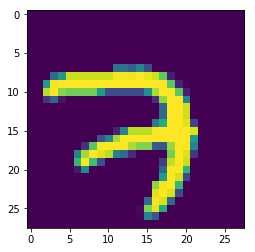

In [77]:
plt.imshow(image.reshape(28,28))

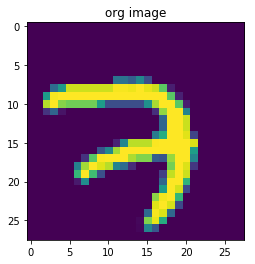

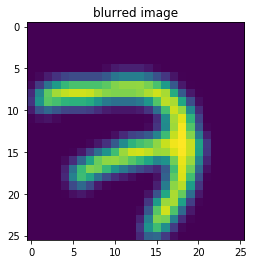

In [79]:
# a gaussian blur kernel
gaussian_kernel = torch.tensor([[1., 2, 1], [2, 4, 2], [1, 2, 1]]) / 16.0

conv = nn.Conv2d(1, 1, 3)
# manually set the conv weight
conv.weight.data[:] = gaussian_kernel

convolved = conv(image_torch)

plt.title('org image')
plt.imshow(image_torch.view(28, 28).detach().numpy())
plt.show()

plt.title('blurred image')
plt.imshow(convolved.view(26, 26).detach().numpy())
plt.show()

The image is blurred as expected.

In practice, we learn many kernels at a time. In this example, we take in an RGB image(3 channels) and output a 16 channels image. 

After an activation function, that could be used as input to another Conv2d module.

In [80]:
im_channels = 3 # RGB images are 3 channels; Black and White, 1 channel
out_channels = 16 # hyperparameter we can tune
kernel_size = 3 # hyperparameter we can tune
batch_size = 4
image_width = 32
image_height = 32

im = torch.randn(batch_size, im_channels, image_width, image_height)

conv = nn.Conv2d(im_channels, out_channels, kernel_size)
convolved = conv(im) # a module we can call

print("im shape:", im.shape)
print('convolved shape:', convolved.shape)

im shape: torch.Size([4, 3, 32, 32])
convolved shape: torch.Size([4, 16, 30, 30])


### Useful links:

+ [60 minute PyTorch Tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
+ [PyTorch Docs](https://pytorch.org/docs/stable/index.html)
+ [Lecture notes on Auto-Diff](https://courses.cs.washington.edu/courses/cse446/19wi/notes/auto-diff.pdf)

## Custom Datasets, DataLoaders

This is modified from pytorch official tutorial.<https://chsasank.github.io>

PyTorch provides many tools to prepare data, make data loading easy and code more readable.

In this tutorial, we will see how to load and preprocess/augment data from a non trivial dataset.

### Dataset class

$torch.utils.data.Dataset$ is an abstract class representing a dataset. Your custom dataset should inherit $Dataset$ and override the follosing methods:

+ __len__ so that len(dataset) returns the size of the dataset.
+ __getitem__ to support the indexing such that dataset[i] can be used to get $i$ th sample

Let us create a dataset class for our face landmarks dataset. We will read the csv in __int__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict {'image': image, 'landmarks':landmark}. Our dataset will take an optional argument $transform$ so that any required processing can be applied on the sample.We will see the usefulness of $transform$ in the next section

In [81]:
from torch.utils.data import Dataset, DataLoader

class FakeDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

By using a simple $for$ loop to iterate over the data, we are losing a lot of features. In particular:

+ Batching the data
+ Shuffling the data
+ Load the data in parallel using $multiprocessing$ workers.

$torch.utils.data.DataLoader$ is an iterator which provides all these features. Parameters used below should be clear. You can specify how exactly the samples need to be batched using $collate_fn$. However, default collate should work fine for most use cases.

In [82]:
x = np.random.rand(100, 10)
y = np.random.rand(100)

dataset = FakeDataset(x, y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched)

0 [tensor([[0.5731, 0.3522, 0.8924, 0.7387, 0.1603, 0.6738, 0.8475, 0.5324, 0.2867,
         0.9676],
        [0.6065, 0.7564, 0.6226, 0.1509, 0.7928, 0.6722, 0.2665, 0.0260, 0.8709,
         0.4901],
        [0.1946, 0.8254, 0.7107, 0.9242, 0.9325, 0.9566, 0.4936, 0.2932, 0.3205,
         0.7291],
        [0.9846, 0.5993, 0.0100, 0.3986, 0.8331, 0.0473, 0.9524, 0.0777, 0.5083,
         0.3032]], dtype=torch.float64), tensor([0.3798, 0.0600, 0.2585, 0.2189], dtype=torch.float64)]
1 [tensor([[0.7790, 0.8279, 0.0550, 0.0412, 0.0761, 0.8209, 0.3106, 0.3042, 0.8627,
         0.7871],
        [0.0785, 0.4358, 0.4960, 0.4975, 0.2461, 0.2620, 0.9665, 0.4101, 0.4390,
         0.7586],
        [0.8214, 0.3621, 0.4067, 0.4915, 0.5756, 0.0225, 0.3004, 0.0227, 0.6835,
         0.3854],
        [0.7188, 0.4558, 0.4876, 0.2920, 0.0415, 0.0202, 0.7813, 0.3701, 0.5999,
         0.9614]], dtype=torch.float64), tensor([0.1186, 0.6269, 0.0943, 0.3152], dtype=torch.float64)]
2 [tensor([[0.4776, 0.9418, 0.

## Mixed Precision Training

Author: Chi-Liang Liu <https://liangtaiwan.github.io> Ref: https://github.com/NVIDIA/apex Using mixed precision to train your networks can be:

+ 2-4x faster
+ memory-efficient in only 3 lines of Python

### Apex

NVIDIA-maintained utilities to steamline mixed precision and distributed training in PyTorch. Some of the code here will be included in upstream PyTorch eventually. The intention of Apex is to make up-to-date utilities available to users as quickly as possible.

#### Apex.amp

Amp allows users to easily experiment with different pure and mixed precision modes. Commonly-used default modes are chosen by selecting an "optimization level" or **opt_level**; each **opt_level** establishes a set of properties that govern Amp's implementation of pure or mixed precision training. Finer-grained control of how a given **opt_level** behaves can be achieved by passing values for particular properties directly to *amp.initialize*. These manually specified values override the defaults established by the **opt_level**.

In [ ]:
fromfrom  apexapex  importimport  ampamp

  # Declare model and optimizer as usual, with default (FP32) precision# Decla 
model = torch.nn.Linear(10, 100).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Allow Amp to perform casts as required by the opt_level
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
...
# loss.backward() becomes:
with amp.scale_loss(loss, optimizer) as scaled_loss:
    scaled_loss.backward()
...